#**Midterm project**

##**Describe the problem and how ML can help**
The **Adult (Census Income)** dataset from the UCI Machine Learning Repository contains demographic and employment data from the 1994 U.S. Census.
The goal is to predict whether a person earns more than `$50,000` per year based on features such as age, education, occupation, hours worked per week, and others.

This is a binary classification problem (`≤50K` vs.` >50K`).

Machine learning can help by:
- Automatically learning relationships between demographic factors and income level.
- Identifying key predictors of high income (e.g., education, occupation, work hours).
- Supporting data-driven decision making for social, economic, or marketing analyses.


Common algorithms used include **Logistic Regression** and **XGBoost**.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

##**Load dataset**

In [2]:
!wget -O adult.csv https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2025-11-09 15:21:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.csv’

adult.csv               [  <=>               ]   3.79M  9.64MB/s    in 0.4s    

2025-11-09 15:21:19 (9.64 MB/s) - ‘adult.csv’ saved [3974305]



In [3]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv('adult.csv', header=None, names=columns, sep=',', engine='python')

##**EDA**

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Clean whitespace and missing values
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.replace("?", np.nan)

In [6]:
print("Dataset shape:", df.shape)

Dataset shape: (32561, 15)


In [7]:
print(df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


In [8]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


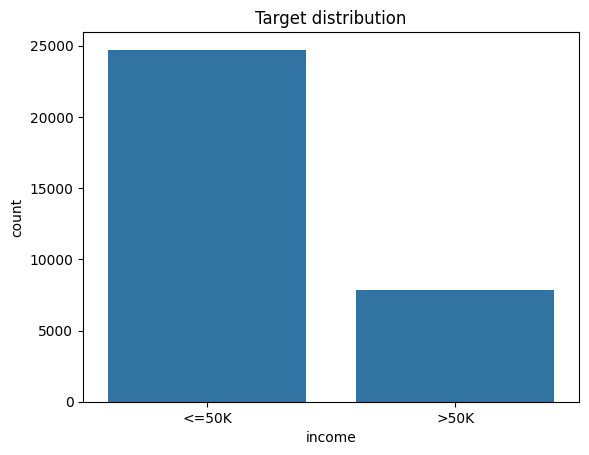

In [9]:
# Quick look at target balance
sns.countplot(x='income', data=df)
plt.title("Target distribution")
plt.show()

In [10]:
# Numeric summary
df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
age,32561.0,38.581647,13.640433,17.0,17.0,19.0,28.0,37.0,48.0,63.0,74.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,27185.8,39460.0,117827.0,178356.0,237051.0,379682.0,510072.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,3.0,5.0,9.0,10.0,12.0,14.0,16.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,0.0,0.0,5013.0,15024.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1980.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,8.0,18.0,40.0,40.0,45.0,60.0,80.0,99.0


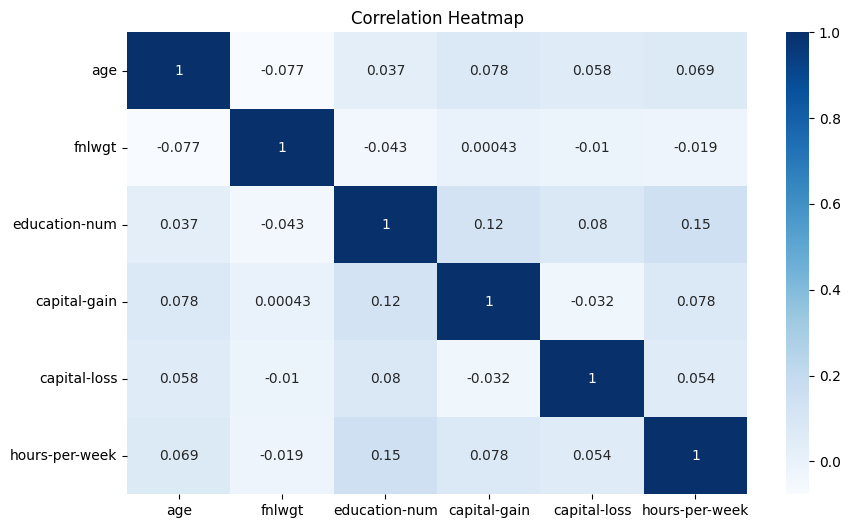

In [11]:
# Correlation of numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

##**Preparing the dataset**

In [12]:
# Binary target
df['income'] = df['income'].str.strip()
df['target'] = (df['income'] == '>50K').astype(int)
df = df.drop(['income'], axis=1)

In [13]:
# Handle missing categorical values with mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

In [14]:
# Split dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42, stratify=df_full_train['target'])

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

Train: 19536 | Val: 6512 | Test: 6513


In [15]:
# Reset indexes
for part in [df_train, df_val, df_test]:
    part.reset_index(drop=True, inplace=True)

In [16]:
# Separate target
y_train = df_train.target.values
y_val   = df_val.target.values
y_test  = df_test.target.values

for part in [df_train, df_val, df_test]:
    part.drop(columns=['target'], inplace=True)

In [17]:
# Vectorize categorical features
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

print("Feature matrix shape:", X_train.shape)

Feature matrix shape: (19536, 105)


##**Logistic regression classifier**

In [18]:
model_lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_val)
y_pred_proba_lr = model_lr.predict_proba(X_val)[:, 1]

acc_lr = accuracy_score(y_val, y_pred_lr)
roc_lr = roc_auc_score(y_val, y_pred_proba_lr)

In [19]:
print("\n=== Logistic Regression Results ===")
print(f"Accuracy: {acc_lr:.4f}")
print(f"ROC-AUC:  {roc_lr:.4f}")
print(classification_report(y_val, y_pred_lr))


=== Logistic Regression Results ===
Accuracy: 0.7938
ROC-AUC:  0.6098
              precision    recall  f1-score   support

           0       0.80      0.96      0.88      4944
           1       0.69      0.26      0.38      1568

    accuracy                           0.79      6512
   macro avg       0.75      0.61      0.63      6512
weighted avg       0.78      0.79      0.76      6512



##**XGBoost classifier**

In [20]:
model_xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    eval_metric="logloss",
    n_jobs=-1
)

model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = model_xgb.predict(X_val)
y_pred_proba_xgb = model_xgb.predict_proba(X_val)[:, 1]

acc_xgb = accuracy_score(y_val, y_pred_xgb)
roc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)

In [21]:
print("\n=== XGBoost Results ===")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"ROC-AUC:  {roc_xgb:.4f}")
print(classification_report(y_val, y_pred_xgb))


=== XGBoost Results ===
Accuracy: 0.8687
ROC-AUC:  0.9233
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4944
           1       0.76      0.66      0.71      1568

    accuracy                           0.87      6512
   macro avg       0.83      0.80      0.81      6512
weighted avg       0.86      0.87      0.87      6512



##**Evaluation on Test Set**

In [22]:
# Logistic Regression
y_test_pred_lr = model_lr.predict(X_test)
y_test_proba_lr = model_lr.predict_proba(X_test)[:, 1]
acc_test_lr = accuracy_score(y_test, y_test_pred_lr)
roc_test_lr = roc_auc_score(y_test, y_test_proba_lr)

In [23]:
# XGBoost
y_test_pred_xgb = model_xgb.predict(X_test)
y_test_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
acc_test_xgb = accuracy_score(y_test, y_test_pred_xgb)
roc_test_xgb = roc_auc_score(y_test, y_test_proba_xgb)

In [24]:
print(f"Logistic Regression  → Accuracy: {acc_test_lr:.4f} | ROC-AUC: {roc_test_lr:.4f}")
print(f"XGBoost              → Accuracy: {acc_test_xgb:.4f} | ROC-AUC: {roc_test_xgb:.4f}")

Logistic Regression  → Accuracy: 0.7979 | ROC-AUC: 0.6112
XGBoost              → Accuracy: 0.8735 | ROC-AUC: 0.9306


##**Visualization**

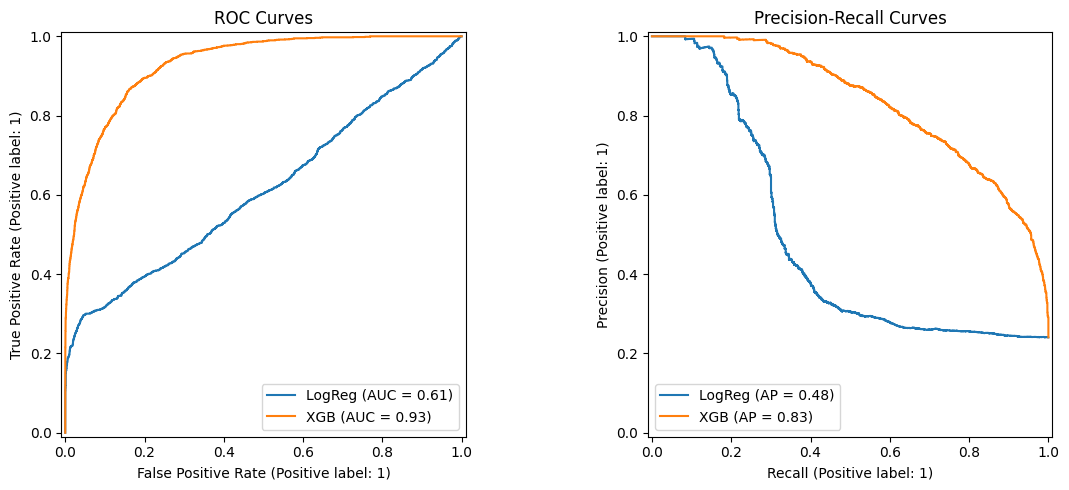

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test, y_test_proba_lr, ax=ax[0], name='LogReg')
RocCurveDisplay.from_predictions(y_test, y_test_proba_xgb, ax=ax[0], name='XGB')
ax[0].set_title('ROC Curves')

PrecisionRecallDisplay.from_predictions(y_test, y_test_proba_lr, ax=ax[1], name='LogReg')
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba_xgb, ax=ax[1], name='XGB')
ax[1].set_title('Precision-Recall Curves')

plt.tight_layout()
plt.show()

##**Conclusions**

**XGBoost performed better overall. It captured non-linear relationships and feature interactions that Logistic Regression could not.**